In [1]:
import torch
import matplotlib.pyplot as plt
import h5py

from autoencoder import Autoencoder

In [2]:
with h5py.File('../../data/smoke_plume_64x64/SmokePlume_R0.50_3.h5', 'r') as f:
    source = f['source'][:]
    density = f['density'][:]
    vorticity = f['vorticity'][:]
    pressure = f['pressure'][:]

In [3]:
density = torch.from_numpy(density[9::10, ...])[:16]
vorticity = torch.from_numpy(vorticity[9::10, ...])[:16]
pressure = torch.from_numpy(pressure[9::10, ...])[:16]

In [4]:
def normalize(original_data: torch.Tensor, norm2pm1: bool=True):
    loc_min = original_data.min()
    loc_max = original_data.max()
    norm_data = (original_data - loc_min) / (loc_max - loc_min)
    if norm2pm1:
        norm_data = 2 * norm_data - 1
    
    return norm_data, loc_min, loc_max

def unnormalize(norm_data: torch.Tensor, loc_min: torch.Tensor, loc_max: torch.Tensor, pm1to01: bool=True):
    if pm1to01:
        norm_data = (norm_data + 1) / 2
    original_data = norm_data * (loc_max - loc_min) + loc_min
    
    return original_data

In [5]:
density_norm, density_min, density_max = normalize(density, norm2pm1=False)
vorticity_norm, vorticity_min, vorticity_max = normalize(vorticity, norm2pm1=False)
pressure_norm, pressure_min, pressure_max = normalize(pressure, norm2pm1=False)

In [6]:
input = torch.stack([density_norm, vorticity_norm, pressure_norm], dim=0).float().permute(2, 0, 1, 3, 4)

In [7]:
vae = Autoencoder(in_channels=3, emb_channels=4, use_attn_in_bottleneck=True, use_variational=True).cuda()
vae.load_state_dict(torch.load('./checkpoint/sp64x64_VAE_beta0.5_attn_ELU_epoch150-300.pt'))

<All keys matched successfully>

In [8]:
input = input[:8]

In [9]:
pred = vae(input.cuda())

In [10]:
x = pred['x'].detach().cpu()
x_hat = pred['x_hat'].detach().cpu()

In [11]:
x_hat.shape

torch.Size([8, 3, 16, 64, 64])

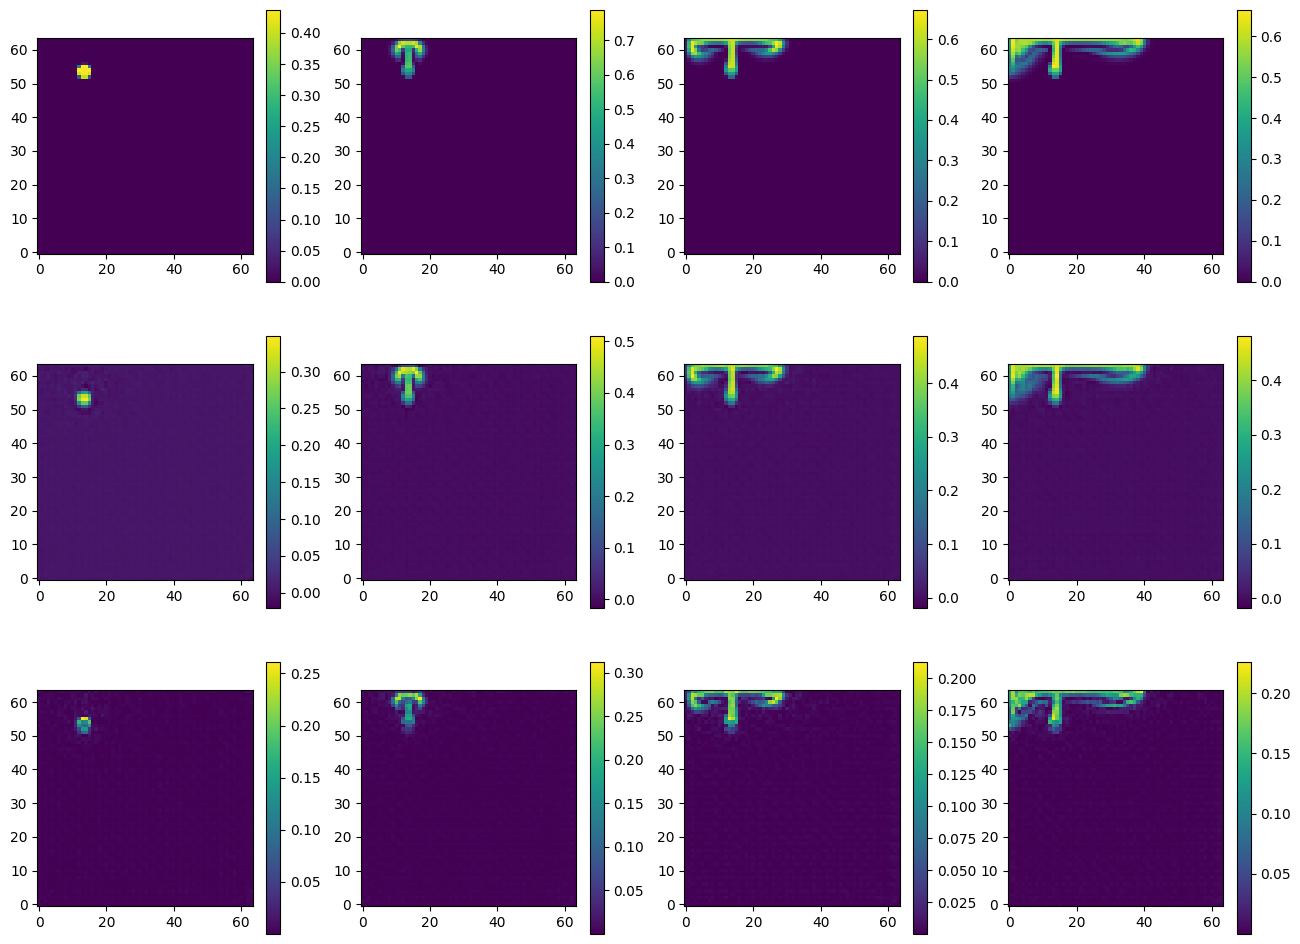

In [17]:
n = 1
fig, ax = plt.subplots(3, 4, figsize=(16, 12))
for i in range(4):
    im1 = ax[0, i].imshow(x[n, 0, i*4], origin='lower')
    plt.colorbar(im1, ax=ax[0, i])
    im2 = ax[1, i].imshow(x_hat[n, 0, i*4], origin='lower')
    plt.colorbar(im2, ax=ax[1, i])
    im3 = ax[2, i].imshow(torch.abs(x[n, 0, i*4]-x_hat[n, 0, i*4]), origin='lower')
    plt.colorbar(im3, ax=ax[2, i])
    